# Hands-on: model selection based on error measurement

### Master

<br>
<b style="font-family:Fantasy">Giuliano Langella</b> &nbsp; &nbsp;
<b style="font-family:Arial">glangella@unina.it</b>

<b>Tobler's Low of Geography (1970): <br><em>$\quad$ "Everything is related to everything else, but near things are more related than distant things".</em></b>

---

## Data | random subsets

In [1]:
setwd('/home/jovyan/work/Didattica/esercizi/DTA/')

In [2]:
library(readr)
tmean <- read_csv("XY_Tmean.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  Xcoord = col_double(),
  Ycoord = col_double(),
  Tmean = col_double()
)




In [3]:
dim(tmean)

[1] 493   3

In [4]:
n <- dim(tmean)[1]
n

[1] 493

### SPDF

In [5]:
require(sp)
coordinates(tmean) = ~Xcoord+Ycoord

Loading required package: sp



In [6]:
proj4string(tmean) <- CRS('+init=epsg:32633')

In [7]:
summary(tmean)

Object of class SpatialPointsDataFrame
Coordinates:
           min     max
Xcoord  398275  567061
Ycoord 4430586 4592903
Is projected: TRUE 
proj4string :
[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs]
Number of points: 493
Data attributes:
     Tmean        
 Min.   : 0.3347  
 1st Qu.: 1.4522  
 Median : 3.2497  
 Mean   : 3.5548  
 3rd Qu.: 5.0767  
 Max.   :12.6371  

### split validation subset

we want 20% data forming the validation subset

In [8]:
n_val <- n * 20 / 100
n_val

[1] 98.6

In [9]:
n_val = 100

In [10]:
val_idx <- sample(1:n, n_val)
val_idx

[1] 115 102 215 199 460 293 448  10 253  42 176 338  34  31 279 207 132 336
 [19] 479 354 325 219 147 428 109 178   3 117 466 225  72  87 268 173 349 323
 [37] 281 484  19 144 266 201 468 230 404  22 362 406 203 150 347 204 382 287
 [55]  77 491 222 300 376 439  12 289  79 330  18 262 188 467 314 161 322   1
 [73]  71 232  16 182 237 388 343 261  44 135  74 224 258 302 465 257 100 370
 [91] 473 344   7  62 121  84 212 282  13 375

Set the seed in the random number generator, in order to get always the same list of random indexes:

In [11]:
set.seed(3008)
val_idx <- sample(1:n, n_val)
val_idx

[1] 388 385 387 462 436 381 116 146 448 204  43  49 459 325 453 166 460 125
 [19] 468 226  12 232 243 304  67 423 256  11 111  45 425 162 149 221 474 276
 [37] 246 118  75  97 316 212 193 300  74 330 234 433 223 318  15 441 168 473
 [55] 173 137 294 250 353 307 384 249 184  27 217 485 247 261 337  20 229 406
 [73] 415 144 117 192  39 366   2 421  10 390 358  44 467 338 163   4 109 491
 [91] 225 251 449  38 335 153  55 450 478 492

Split

In [12]:
tm_val <- tmean[val_idx,]
dim(tm_val)

[1] 100   1

In [13]:
tm_tr <- tmean[-val_idx,]
dim(tm_tr)

[1] 393   1

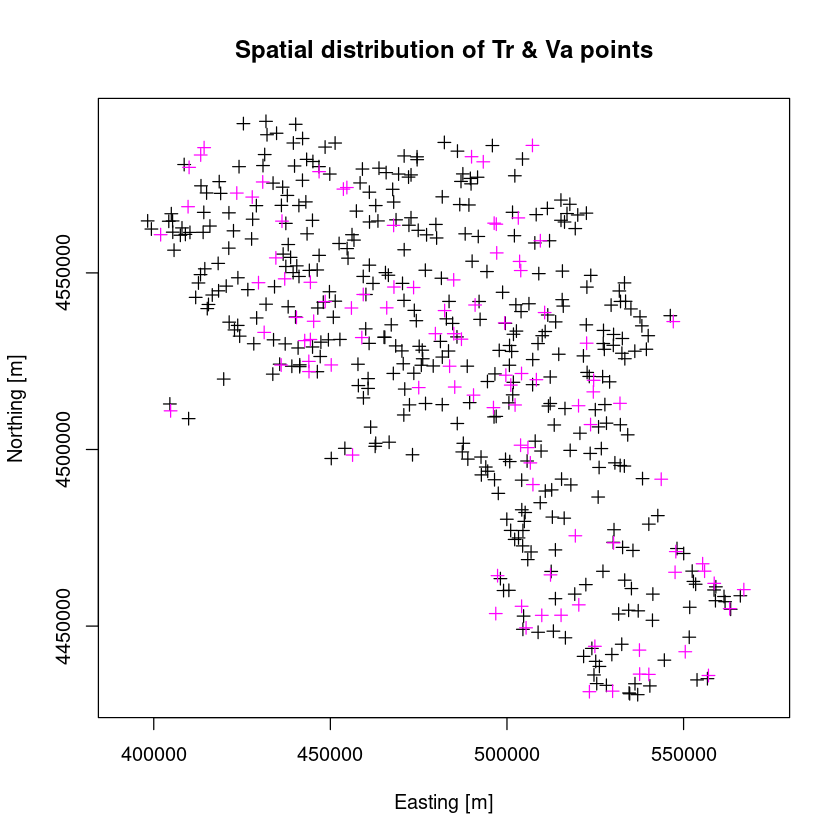

In [14]:
plot(tm_tr,col='black', 
     main="Spatial distribution of Tr & Va points",
     xlab="Easting [m]",ylab="Northing [m]")
plot(tm_val,col='magenta',add=TRUE)
box()
axis(1,labels=TRUE)
axis(2,labels=TRUE)

## Error definition

In [15]:
rmse <- function(M,P){
    # INPUTS
    #  M    : measurements
    #  P    : predictions
    
    n <- length(M)
    
    E = (M - P)
    S = E^2
    M = sum(S) / n
    R = sqrt(M)
    
    R
}

In [16]:
rmse( tm_val$Tmean , tm_val$Tmean )

[1] 0

In [17]:
rmse( tm_val$Tmean , tm_val$Tmean[1:98] )

Warning message in M - P:
“longer object length is not a multiple of shorter object length”


[1] 0.5582876

In [18]:
rmse <- function(M,P){
    # INPUTS
    #  M    : measurements
    #  P    : predictions
    
    # Checek that M & P have the same size:
    n1 <- length(M)
    n2 <- length(P)
    if(n1>n2 | n1<n2){
        print("Input vectors have different size!")
        return(NA)
    }
    
    n <- length(M)
    
    E = (M - P)
    S = E^2
    M = sum(S) / n
    R = sqrt(M)
    
    R
}

In [19]:
rmse( tm_val$Tmean , tm_val$Tmean[1:98] )

[1] "Input vectors have different size!"


[1] NA

## Models

In [20]:
tm_mod <- vector(length=n_val,mode='numeric')
head(tm_mod)

[1] 0 0 0 0 0 0

### NULL Model

In [21]:
tm_null = tm_mod

In [22]:
tm_null[1:n_val] <- mean(tm_tr$Tmean)
head(tm_null)

[1] 3.623176 3.623176 3.623176 3.623176 3.623176 3.623176

In [23]:
RMSE_NULL <- rmse(tm_val$Tmean,tm_null)
RMSE_NULL

[1] 1.98449

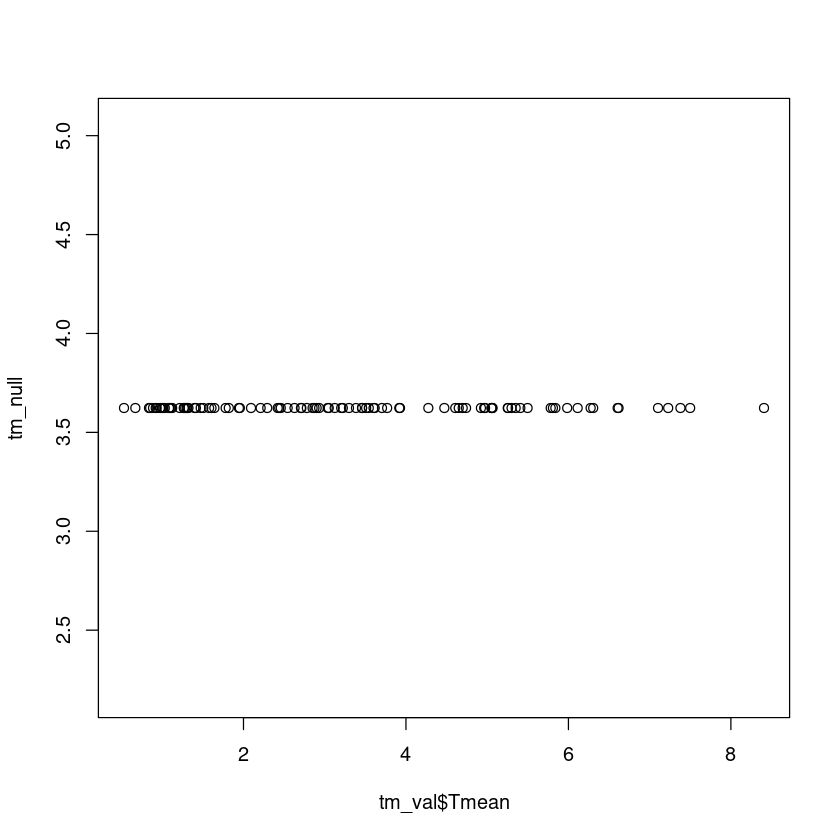

In [24]:
plot(tm_val$Tmean,tm_null,type='p')

### Proximity Model

In [25]:
require(gstat)

Loading required package: gstat



In [26]:
tm_thie <- idw(Tmean~1,tm_tr,newdata=tm_val,nmax=1)
summary(tm_thie)

[inverse distance weighted interpolation]


Object of class SpatialPointsDataFrame
Coordinates:
           min     max
Xcoord  401949  567061
Ycoord 4431432 4586090
Is projected: TRUE 
proj4string :
[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs]
Number of points: 100
Data attributes:
   var1.pred          var1.var  
 Min.   : 0.4889   Min.   : NA  
 1st Qu.: 1.9310   1st Qu.: NA  
 Median : 3.3429   Median : NA  
 Mean   : 3.5273   Mean   :NaN  
 3rd Qu.: 4.7470   3rd Qu.: NA  
 Max.   :11.3882   Max.   : NA  
                   NA's   :100  

In [27]:
RMSE_THIES <- rmse(tm_val$Tmean,tm_thie$var1.pred)
RMSE_THIES

[1] 1.547318

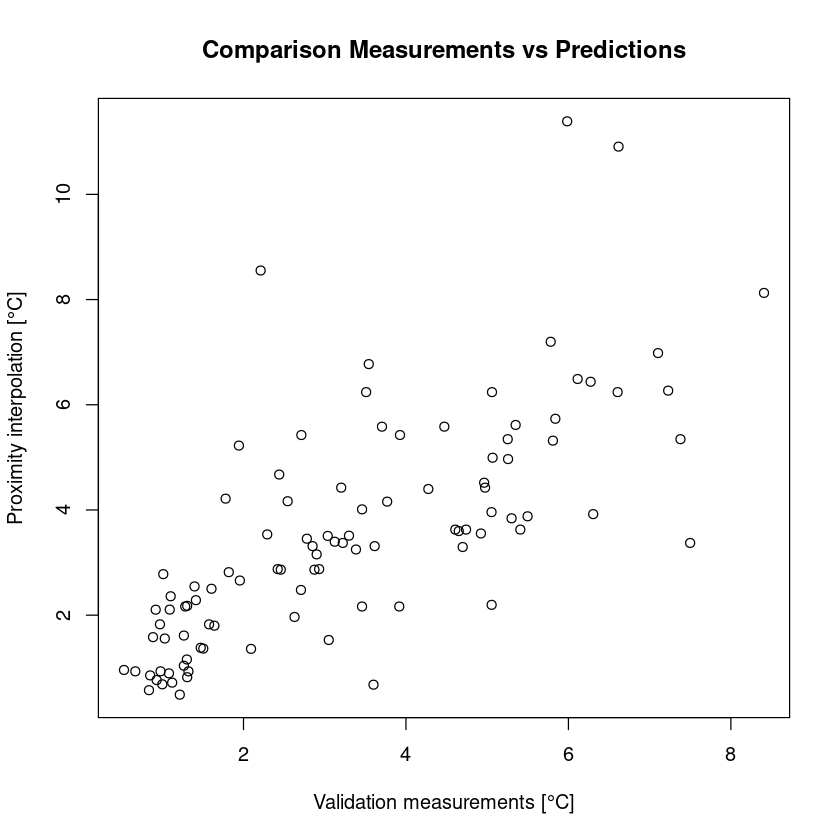

In [28]:
plot(tm_val$Tmean,tm_thie$var1.pred,type='p',
     xlab="Validation measurements [°C]",
     ylab="Proximity interpolation [°C]",
     main="Comparison Measurements vs Predictions"
    )

### Nearest Neighbour

In [29]:
tm_nn <- idw(Tmean~1,tm_tr,newdata=tm_val,idp=0,nmax=3)

[inverse distance weighted interpolation]


In [30]:
RMSE_NN <- rmse(tm_val$Tmean,tm_nn$var1.pred)
RMSE_NN

[1] 1.588777

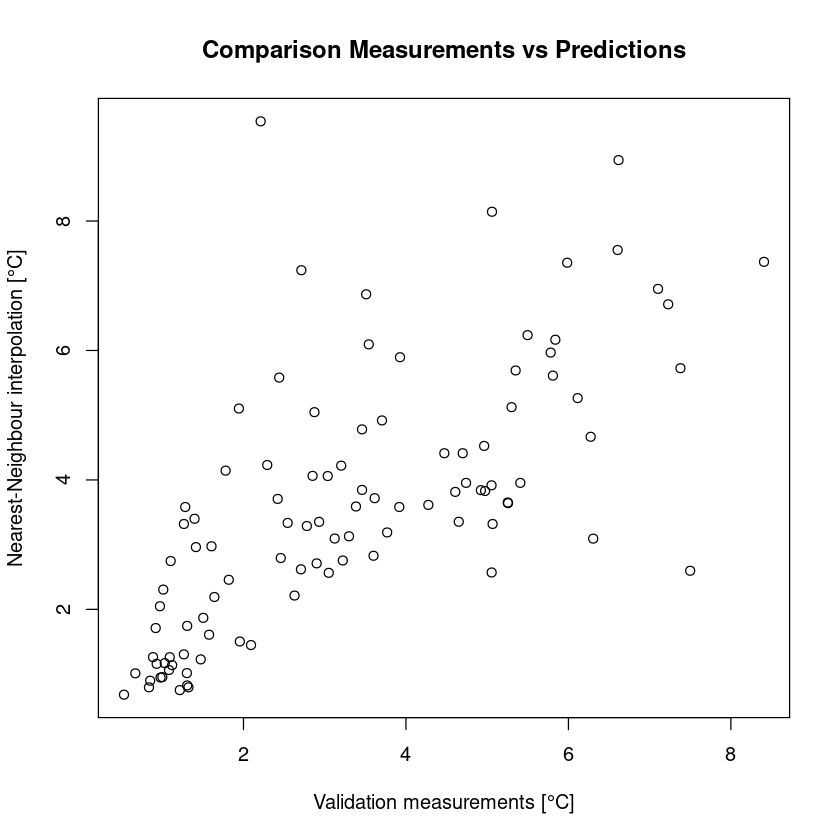

In [31]:
plot(tm_val$Tmean,tm_nn$var1.pred,type='p',
     xlab="Validation measurements [°C]",
     ylab="Nearest-Neighbour interpolation [°C]",
     main="Comparison Measurements vs Predictions"    
    )

### Inverse Distance Weigthed

In [32]:
tm_idw <- idw(Tmean~1,tm_tr,newdata=tm_val,idp=2,
    maxdis=12000,nmin=4,nmax=10
   )

[inverse distance weighted interpolation]


In [33]:
head(tm_idw$var1.pred)

[1] 5.095324       NA 2.856922 2.328754 6.623992 3.574034

In [34]:
sum(tm_idw$var1.pred)

[1] NA

In [35]:
sum(tm_idw$var1.pred,na.rm=TRUE)

[1] 354.1772

In [36]:
rmse(tm_val$Tmean,tm_idw$var1.pred)

[1] NA

In [37]:
rmse <- function(M,P){
    # INPUTS
    #  M    : measurements
    #  P    : predictions
    
    # Checek that M & P have the same size:
    n1 <- length(M)
    n2 <- length(P)
    if(n1>n2 | n1<n2){
        print("Input vectors have different size!")
        return(NA)
    }
    
    n <- length(M)
    
    E = (M - P)
    S = E^2
    M = sum(S,na.rm=TRUE) / n
    R = sqrt(M)
    R
}

In [38]:
rmse(tm_val$Tmean,tm_idw$var1.pred)

[1] 1.507216

Explain the difference between the rmse function w/out **na.rm=TRUE**:

In [39]:
M <- tm_val$Tmean
P <- tm_idw$var1.pred

In [40]:
n <- length(M)
E = (M - P)
S = E^2
M = sum(S) / n

In [41]:
M

[1] NA

In [42]:
M = sum(S,na.rm=TRUE) / n
sqrt(M)

[1] 1.507216

In [43]:
RMSE_IDW <- rmse(tm_val$Tmean,tm_idw$var1.pred)
RMSE_IDW

[1] 1.507216

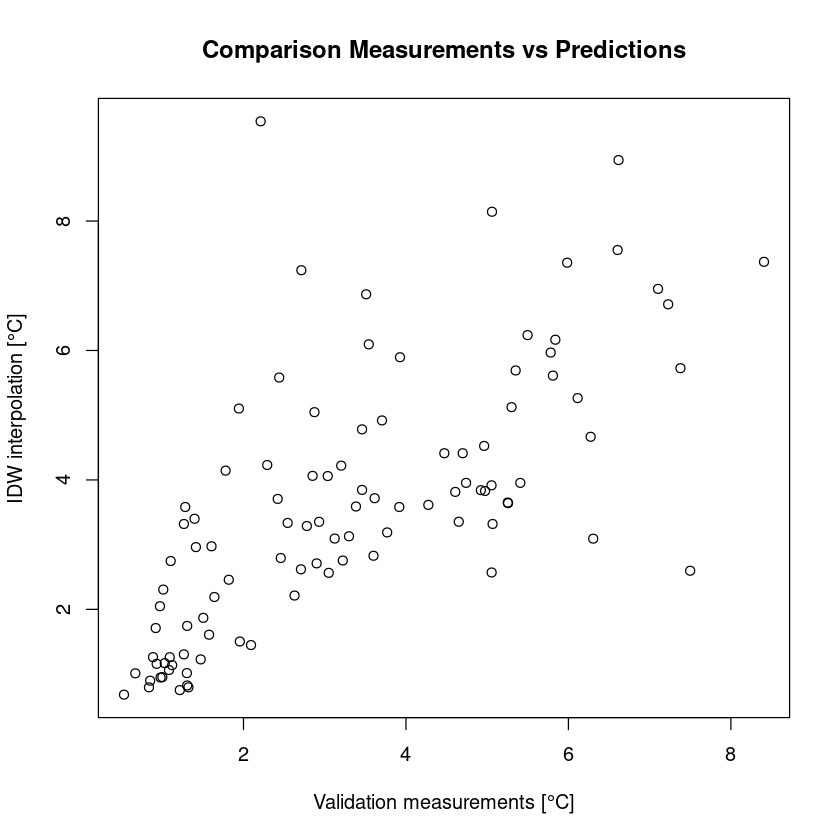

In [44]:
plot(tm_val$Tmean,tm_nn$var1.pred,type='p',
     xlab="Validation measurements [°C]",
     ylab="IDW interpolation [°C]",
     main="Comparison Measurements vs Predictions"    
    )     

### Kriging

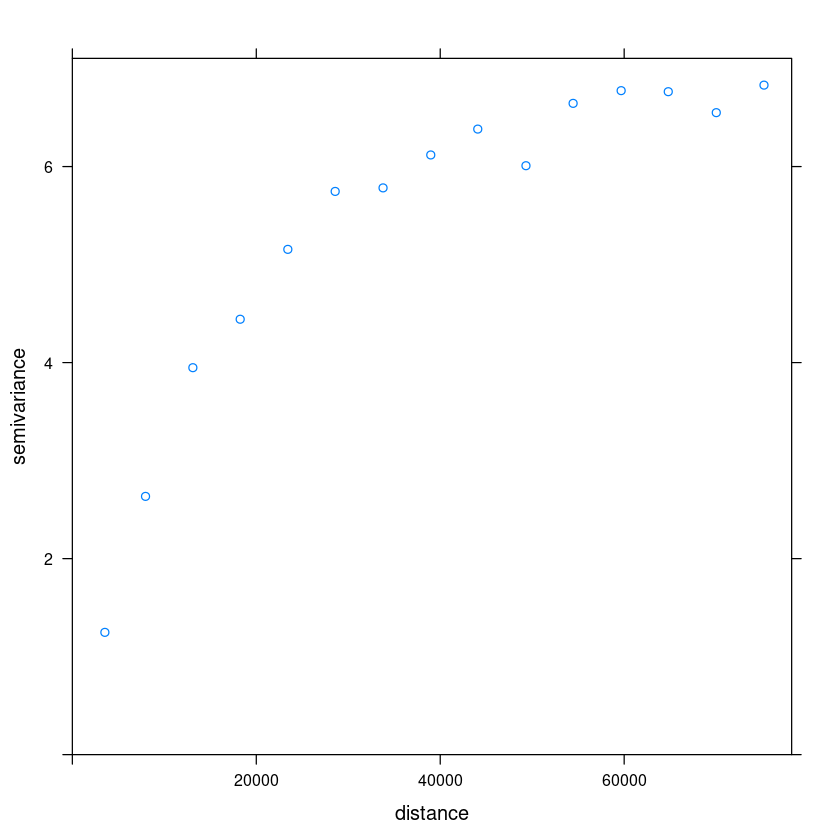

In [45]:
tm.vgm <- variogram(Tmean~1,tm_tr)
plot(tm.vgm)

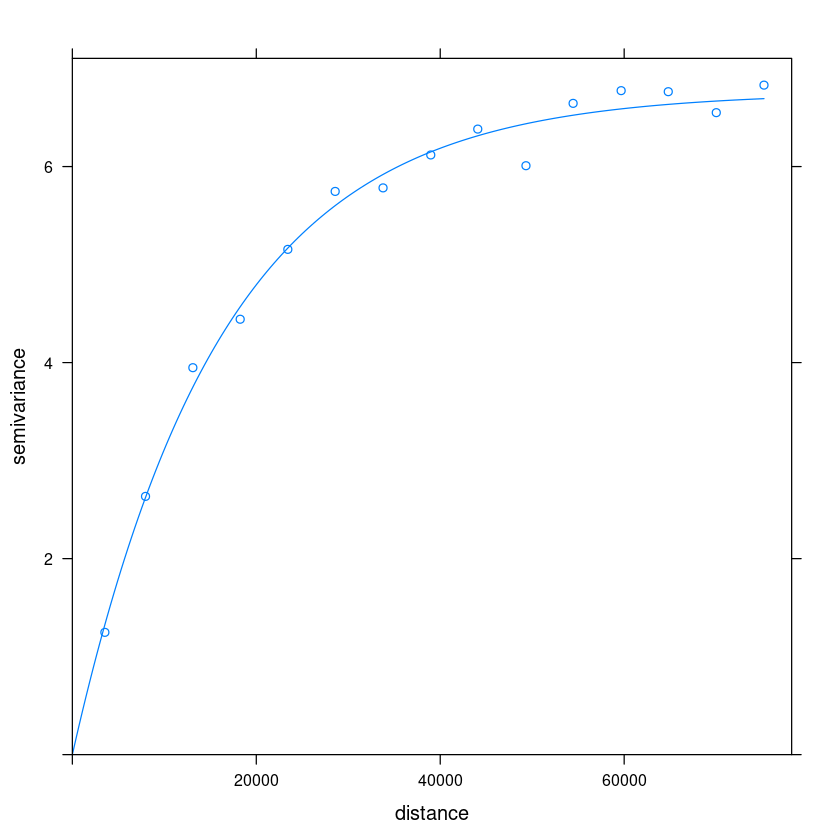

In [46]:
tm.mod <- fit.variogram(tm.vgm,model=vgm(5,'Exp',20000,1))
plot(tm.vgm,tm.mod)

In [47]:
tm.mod

,model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Nug,0.000000,0.00,0.0,0,0,0,1,1
2,Exp,6.757928,16186.66,0.5,0,0,0,1,1


In [48]:
tm_kr <- krige(Tmean~1,tm_tr,model=tm.mod,
                   newdata=tm_val,
                   maxdist=12000,nmin=4,nmax=10
                  )
summary(tm_kr)

[using ordinary kriging]


Object of class SpatialPointsDataFrame
Coordinates:
           min     max
Xcoord  401949  567061
Ycoord 4431432 4586090
Is projected: TRUE 
proj4string :
[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs]
Number of points: 100
Data attributes:
   var1.pred         var1.var     
 Min.   :0.7158   Min.   :0.1462  
 1st Qu.:1.8916   1st Qu.:1.0288  
 Median :3.5419   Median :1.4309  
 Mean   :3.6231   Mean   :1.4310  
 3rd Qu.:4.5987   3rd Qu.:1.8420  
 Max.   :9.5322   Max.   :3.5776  
 NA's   :4        NA's   :4       

In [49]:
RMSE_KR <- rmse(tm_val$Tmean,tm_kr$var1.pred)
RMSE_KR

[1] 1.484688

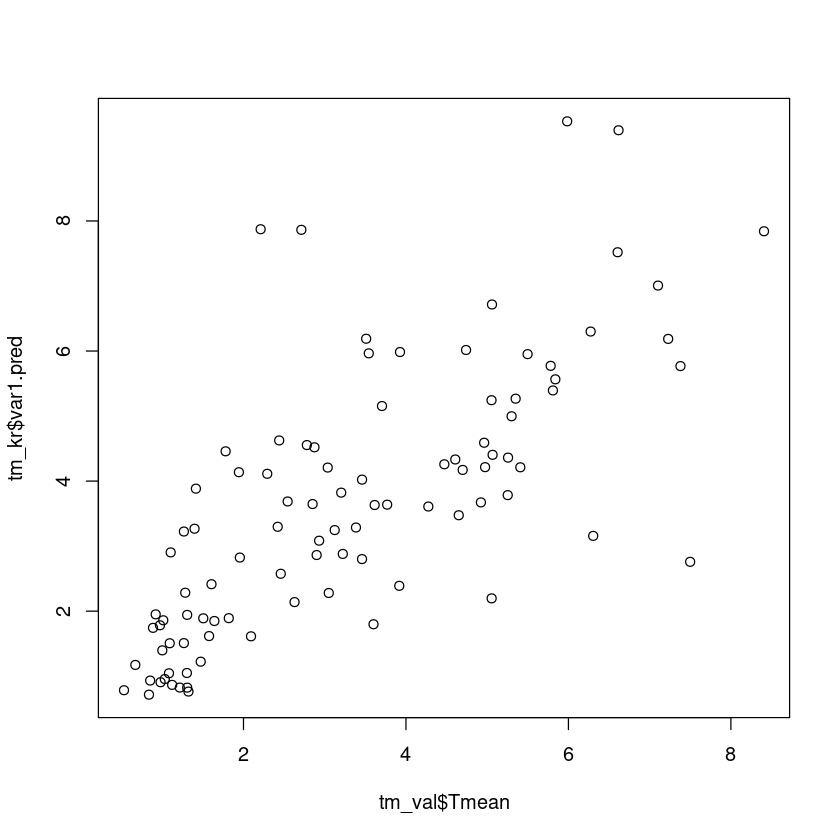

In [50]:
plot(tm_val$Tmean,tm_kr$var1.pred,type='p')

## Selection

In [51]:
RMSE_NULL
RMSE_THIES
RMSE_NN
RMSE_IDW
RMSE_KR

[1] 1.98449

[1] 1.547318

[1] 1.588777

[1] 1.507216

[1] 1.484688

Pretty print:

In [52]:
print( paste0("NULL        : ",RMSE_NULL)  )
print( paste0("THIESSN     : ",RMSE_THIES) )
print( paste0("NEIR-NEIGH  : ",RMSE_NN)    )
print( paste0("IDW         : ",RMSE_IDW)   )
print( paste0("KRIGING     : ",RMSE_KR)    )

[1] "NULL        : 1.98449031160638"
[1] "THIESSN     : 1.54731817986328"
[1] "NEIR-NEIGH  : 1.58877740448982"
[1] "IDW         : 1.50721616031581"
[1] "KRIGING     : 1.48468830397586"
